In [1]:
import pandas as pd
import numpy as np
from patsy import dmatrices
import warnings
%pylab inline
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [2]:
#read in data
organic = pd.read_csv('Organics Project Data.csv', names = ['Gender', 'Geographic_Region', 'Loyalty_Status', \
                                                           'Television_Region', 'Affluence_Grade', 'Age',\
                                                            'Loyalty_Card_Tenure', 'target'], skiprows = [0])

In [3]:
#data cleaning
organic = organic.dropna()
organic = organic[organic.Age != "."]
organic = organic[organic['Loyalty_Card_Tenure'] != "."]
organic = organic[organic['Affluence_Grade'] != "."]
organic['Age'] = organic['Age'].astype(np.int64)
organic['Loyalty_Card_Tenure'] = organic['Loyalty_Card_Tenure'].astype(np.int64)
organic['Affluence_Grade'] = organic['Affluence_Grade'].astype(np.int64)
organic['target'] = organic['target'].astype(np.int64)

organic.head(3)

,Gender,Geographic_Region,Loyalty_Status,Television_Region,Affluence_Grade,Age,Loyalty_Card_Tenure,target
0,M,Midlands,Tin,Midlands,10,65,7,1
1,M,North,Tin,N East,13,62,5,0
2,M,Midlands,Silver,East,10,62,3,0


In [4]:
organic.head(3)
#organic['target'].unique()

,Gender,Geographic_Region,Loyalty_Status,Television_Region,Affluence_Grade,Age,Loyalty_Card_Tenure,target
0,M,Midlands,Tin,Midlands,10,65,7,1
1,M,North,Tin,N East,13,62,5,0
2,M,Midlands,Silver,East,10,62,3,0


In [5]:
len(organic)

15401

In [5]:
dtype(organic['Age']).name

'int64'

In [6]:
# create matrices
formula = 'target ~ 0 + Gender + Geographic_Region + Loyalty_Status + Television_Region'+\
          ' + Affluence_Grade + Age + Loyalty_Card_Tenure'
Y, X = dmatrices(formula, organic, return_type = 'dataframe')
Y[:5]
y = Y['target'].values


In [7]:
#split test/train data
from sklearn.model_selection import train_test_split

x_tr, x_te, y_tr, y_te = train_test_split(X, y, test_size = 0.3, random_state = 1)

# Decision Tree

## 1.The big tree


In [8]:
#model fit (the big tree)
import warnings
warnings.filterwarnings('ignore')
from sklearn import tree

tree1 = tree.DecisionTreeClassifier(criterion = 'entropy')
result = tree1.fit(x_tr, y_tr)
print(tree1.tree_.max_depth)

35


In [9]:
tree1.get_depth

<bound method BaseDecisionTree.get_depth of DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')>

In [10]:
#Predcition Accruacy(train)
from sklearn import metrics

tr_pred = tree1.predict(x_tr)
tr_accruacy = metrics.accuracy_score(y_tr, tr_pred)
print(tr_accruacy)

0.988682745825603


In [11]:
#Predcition Accruacy(test)

te_pred = tree1.predict(x_te)
te_accruacy = metrics.accuracy_score(y_te, te_pred)
print(te_accruacy)

0.7169443843323956


In [12]:
#plot the big tree
import graphviz

tree_chart1 = graphviz.Source(tree.export_graphviz(tree1,
                                     out_file=None,
                                     feature_names=X.columns.values,
                                     filled=True))
#output chart
tree_chart1.render('Classification_4_data/incomes', format='png', view = True)


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.243891 to fit


'Classification_4_data/incomes.png'

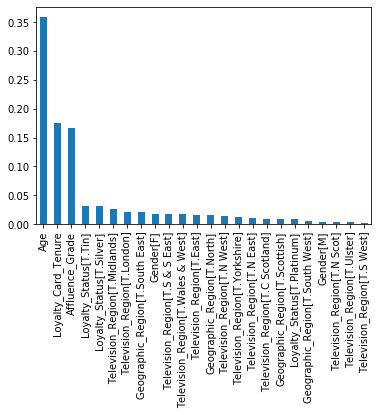

In [13]:
# summarize feature importance

dummy_columns = x_tr.columns.to_list()
importance = tree1.feature_importances_
# Create a zip object from two lists
zipObj = zip(dummy_columns, importance)
# Create a dictionary from zip object
imp_dict = dict(zipObj)

#create a dictionary of importance and convert it to a seires
true_imp_dict = {}
for key in imp_dict:
    if imp_dict[key] > 0:
        true_imp_dict[key] = imp_dict[key]
true_imp_dict = pd.Series(true_imp_dict)
                                      
#plot importance
true_imp_dict.sort_values(ascending = False).plot(kind = 'bar')

## 2.The pruned tree (with CV)

In [14]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

#setup k-fold
kfold = StratifiedKFold(n_splits = 5,
                        shuffle = True)

#CV
cv_dict = {}
for depth in range(1, 11):
    tree2 = tree.DecisionTreeClassifier(criterion = 'entropy', 
                                        max_depth = depth)
    scores = cross_val_score(tree2, 
                             x_tr,
                             y_tr,
                             cv = kfold)
    cv_dict[depth] = mean(scores)
    print("for depth =", depth, ' 5-fold cv average score = ', mean(scores))


for depth = 1  5-fold cv average score =  0.7543599257884972
for depth = 2  5-fold cv average score =  0.7615027829313543
for depth = 3  5-fold cv average score =  0.7839517625231911
for depth = 4  5-fold cv average score =  0.7895176252319109
for depth = 5  5-fold cv average score =  0.7892393320964749
for depth = 6  5-fold cv average score =  0.7866419294990724
for depth = 7  5-fold cv average score =  0.7874768089053803
for depth = 8  5-fold cv average score =  0.7804267161410019
for depth = 9  5-fold cv average score =  0.7814471243042671
for depth = 10  5-fold cv average score =  0.7787569573283859


Text(0.5, 0, 'Depth')

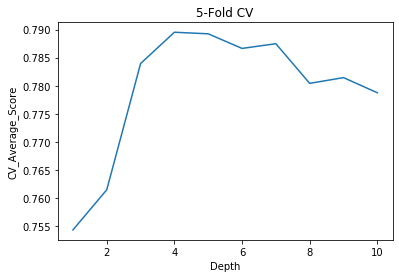

In [15]:
pd.Series(cv_dict).plot()
plt.title("5-Fold CV")
plt.ylabel("CV_Average_Score")
plt.xlabel("Depth")


In [16]:
#From above we obtain optimal depth = 4

#Predcition Accruacy(train)
tree2 = tree.DecisionTreeClassifier(criterion = 'entropy', 
                                    max_depth = 4)
result2 = tree2.fit(x_tr, y_tr)
tr_pred_2 = tree2.predict(x_tr)
tr_accuracy_2 = metrics.accuracy_score(y_tr, tr_pred_2)
print(tr_accuracy_2)

0.7939703153988869


In [17]:
#Predcition Accruacy(test)

te_pred_2 = tree2.predict(x_te)
te_accuracy_2 = metrics.accuracy_score(y_te, te_pred_2)
print(te_accuracy_2)

0.7898723220082233


In [18]:
#plot the pruned tree

tree_chart2 = graphviz.Source(tree.export_graphviz(tree2,
                                     out_file=None,
                                     feature_names=X.columns.values,
                                     filled=True))
#output chart
tree_chart2.render('Classification_4_data/pruned_tree', format='png', view = True)

'Classification_4_data/pruned_tree.png'

Text(0.5, 1.0, 'Feature Importance')

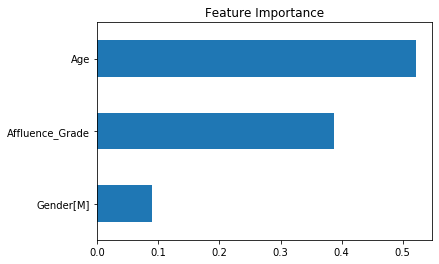

In [19]:
# summarize feature importance

dummy_columns = x_tr.columns.to_list()
importance = tree2.feature_importances_
# Create a zip object from two lists
zipObj = zip(dummy_columns, importance)
# Create a dictionary from zip object
imp_dict = dict(zipObj)

#create a dictionary of importance and convert it to a seires
true_imp_dict = {}
for key in imp_dict:
    if imp_dict[key] > 0:
        true_imp_dict[key] = imp_dict[key]
true_imp_dict = pd.Series(true_imp_dict)
                                      
#plot importance
true_imp_dict.sort_values().plot(kind = 'barh')
plt.title("Feature Importance")

# KNN 
## KNN with k = 15

In [20]:
# ## Knn Model
from sklearn import neighbors

#knn model with k = 15
model = neighbors.KNeighborsClassifier(n_neighbors=15,
                                       weights='uniform',
                                       p=2)

#Fit the model on the design matrices
model.fit(x_tr, y_tr)

#Predict on training
prediction_on_training = model.predict(x_tr)
print(metrics.accuracy_score(y_tr, prediction_on_training))

#Predict on test - a little worse
predicted_classes = model.predict(x_te)
print(metrics.accuracy_score(y_te, predicted_classes))

0.8031539888682746
0.7844622376109067


## CV to find optimal k

### variable importance from optimal KNN model (k=90)

In [21]:
bestKnn = neighbors.KNeighborsClassifier(n_neighbors=90,
                                       weights='uniform',
                                       p=2)

In [24]:
#Permutation importance
from sklearn.inspection import permutation_importance

# fit the model
bestKnn.fit(X, y)

# perform permutation importance
results = permutation_importance(bestKnn, X, y, scoring='accuracy')

# get importance
importance = results.importances_mean


Text(0.5, 1.0, 'Feature Importance')

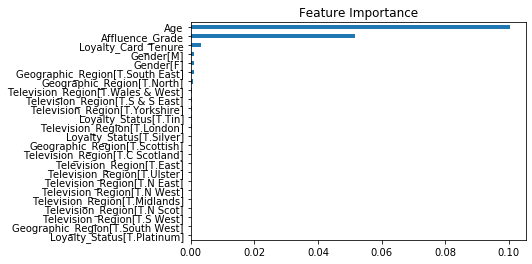

In [25]:
##create a dictionary about variable importance and convert it to a seires
dummy_columns = X.columns.to_list()
zipObj = zip(dummy_columns, importance)
imp_dict = dict(zipObj)
true_imp_dict = {}
for key in imp_dict:
    if abs(imp_dict[key]) > 0:
        true_imp_dict[key] = abs(imp_dict[key])
true_imp_dict = pd.Series(true_imp_dict)

#plot importance
true_imp_dict.sort_values().plot(kind = 'barh')
plt.title("Feature Importance")

In [ ]:
imp_dict

# Logistic Regression

In [ ]:
x_tr

In [26]:
# scale data
from sklearn import preprocessing
#X_scaled = preprocessing.scale(X)
organic['Affluence_Grade'] = preprocessing.scale(organic['Affluence_Grade'])
organic['Age'] = preprocessing.scale(organic['Age'])
organic['Loyalty_Card_Tenure'] = preprocessing.scale(organic['Loyalty_Card_Tenure'])
organic.head(3)

,Gender,Geographic_Region,Loyalty_Status,Television_Region,Affluence_Grade,Age,Loyalty_Card_Tenure,target
0,M,Midlands,Tin,Midlands,0.336803,0.865714,0.096428,1
1,M,North,Tin,N East,1.197639,0.640446,-0.338825,0
2,M,Midlands,Silver,East,0.336803,0.640446,-0.774077,0


In [27]:
# create matrices
formula = 'target ~ 0 + Gender + Geographic_Region + Loyalty_Status + Television_Region'+\
          ' + Affluence_Grade + Age + Loyalty_Card_Tenure'
Y, X = dmatrices(formula, organic, return_type = 'dataframe')
Y[:5]
y = Y['target'].values


In [28]:
#split test/train data
from sklearn.model_selection import train_test_split

x_tr, x_te, y_tr, y_te = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [29]:
#model fit
from sklearn.linear_model import LogisticRegression
logis = LogisticRegression()
result = logis.fit(x_tr, y_tr)

In [30]:
#Train Accruacy
from sklearn import metrics

tr_pred = logis.predict(x_tr)
print(metrics.accuracy_score(y_tr, tr_pred))

0.7842300556586271


In [31]:
#Test Accruacy

te_pred = logis.predict(x_te)
print(metrics.accuracy_score(y_te, te_pred))

0.7937675827742913


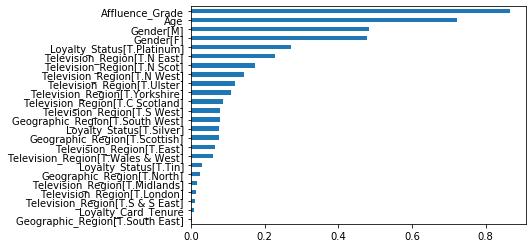

In [32]:
#Feature weight

weights = pd.Series(logis.coef_[0], 
                 index = X.columns.values)
##create a dictionary about variable importance and convert it to a seires
dummy_columns = X.columns.to_list()
zipObj = zip(dummy_columns, weights)
imp_dict = dict(zipObj)
true_imp_dict = {}
for key in imp_dict:
    if abs(imp_dict[key]) > 0:
        true_imp_dict[key] = abs(imp_dict[key])
true_imp_dict = pd.Series(true_imp_dict)

#plot importance
true_imp_dict.sort_values().plot(kind = 'barh')